# Bike Sharing Modeling with Linear Regression

+ Based on the Bike Sharing Dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), also documented in [1]
+ This notebook analyzes the transformed hourly data, prepared and saved by the noteboot L02-BikeSharing-EDA
+ It is adapted from the corresponding notebook in book [2], chapter 6

---
*References*  
[1] Fanaee-T H. and Gama J. 'Event labeling combining ensemble detectors and background knowledge' in 'Progress in Artificial Intelligence' pp. 1-15. Springer, 2013.  
[2] Sarkar D., Bali R. and Sharma T. 'Practical Machine Learning with Python'. Apress, 2018

## Data Loading

### Packages and Settings

In [2]:
%matplotlib inline
# data and plotting packages
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# modeling packages and utilities
import scipy.stats as stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

import mlutils      # our own module with utilities

### Display Settings

In [3]:
pd.options.display.max_colwidth = 60

plt.rcParams['figure.figsize'] = (30, 10)
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

sn.set_style('darkgrid')
sn.set_context('notebook', font_scale=1.5)

### Load Dataset

In [4]:
indatapath = '../data/BikeSharing/hour.pkl'
hour_df = pd.read_pickle(indatapath)
print("Shape of dataset: {}".format(hour_df.shape))

Shape of dataset: (17379, 17)


### Train-Test Split

In [5]:
# X is the dataframe without the last three columns (counts)
# y is the last dataframe column (total_count)
X_train, X_test, y_train, y_test = train_test_split(hour_df.iloc[:, 0:-3], hour_df.iloc[:, -1], 
                                        test_size=0.33, random_state=42)

X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

print("Shape of training set: {}  {}".format(X_train.shape,y_train.shape))
print("Shape of testing set:  {}".format(X_test.shape))

Shape of training set: (11643, 14)  (11643,)
Shape of testing set:  (5736, 14)


### Encode Categoricals (One Hot Encoding)

In [6]:
all_cat_cols = ['season', 'is_holiday', 'weather_cond','is_workday', 'hour', 'weekday', 'month', 'year']
all_num_cols = ['temp', 'humidity', 'windspeed', 'hour', 'weekday','month','year']
subset_cat_cols =  ['season', 'is_holiday','weather_cond','is_workday']

# encode all the categorical columns
# collect the results into a list of dictionaries
encoded_attr_list = []
for col in all_cat_cols:
    return_obj = mlutils.fit_transform_ohe(X_train, col)
    encoded_attr_list.append({'label_enc': return_obj[0],
                              'ohe_enc': return_obj[1],
                              'feature_df': return_obj[2],
                              'col_name': col})

In [7]:
# create a list that contains a dataframe will all the numerical columsn
feature_df_list = [X_train[all_num_cols]]
# extend the list by adding dataframes of encoded categorical columns in subset_cat_cols
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_cols])
# concatenate vertically all the dataframes in the list
train_df_new = pd.concat(feature_df_list, axis=1)

print("Shape of encoded training set: {}".format(train_df_new.shape))
train_df_new.tail()

Shape of encoded training set: (11643, 19)


,temp,humidity,windspeed,hour,weekday,month,year,season_Fall,season_Spring,season_Summer,season_Winter,is_holiday_0,is_holiday_1,weather_cond_1,weather_cond_2,weather_cond_3,weather_cond_4,is_workday_0,is_workday_1
11638,0.46,0.88,0.0896,9,5,4,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11639,0.66,0.34,0.1343,17,5,5,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11640,0.80,0.43,0.2836,12,3,8,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11641,0.24,0.65,0.4179,7,2,2,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11642,0.52,0.83,0.1642,8,4,10,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Linear Regression

In [8]:
# note how we turn y from a one-column dataframe to a column vector
# when we call reshape with one element of the shape tuple being -1, its size gets inferred
X = train_df_new
y = y_train.values.reshape(-1, 1)
# we create an instance of the Linear Regression model class
lin_reg = linear_model.LinearRegression()

# we fit the model and print the results
res = lin_reg.fit(X, y)
coef_df = pd.DataFrame({'Attribute': X.columns.tolist(), 'Coefficient': res.coef_.squeeze()})
print('Intercept: {0:6.4f}'.format(np.asscalar(res.intercept_)))
print('Coefficients:')
print(coef_df)


Intercept: -3.3773
Coefficients:
         Attribute  Coefficient
0             temp   347.203843
1         humidity  -194.410290
2        windspeed    24.754604
3             hour     7.410754
4          weekday     1.537775
5            month    -0.070036
6             year    81.975350
7      season_Fall    46.015214
8    season_Spring     0.406943
9    season_Summer   -24.538641
10   season_Winter   -21.883516
11    is_holiday_0    14.194260
12    is_holiday_1   -14.194260
13  weather_cond_1    -6.017713
14  weather_cond_2     2.864827
15  weather_cond_3   -32.156130
16  weather_cond_4    35.309016
17    is_workday_0    -1.692251
18    is_workday_1     1.692251


### Cross Validation
We fit the model on $k-1$ folds of the training set and make a prediction on the remaining $k$-th fold.  
The number of folds $k$ is passed via the cv argument below.  
Then we plot residuals against observed values.

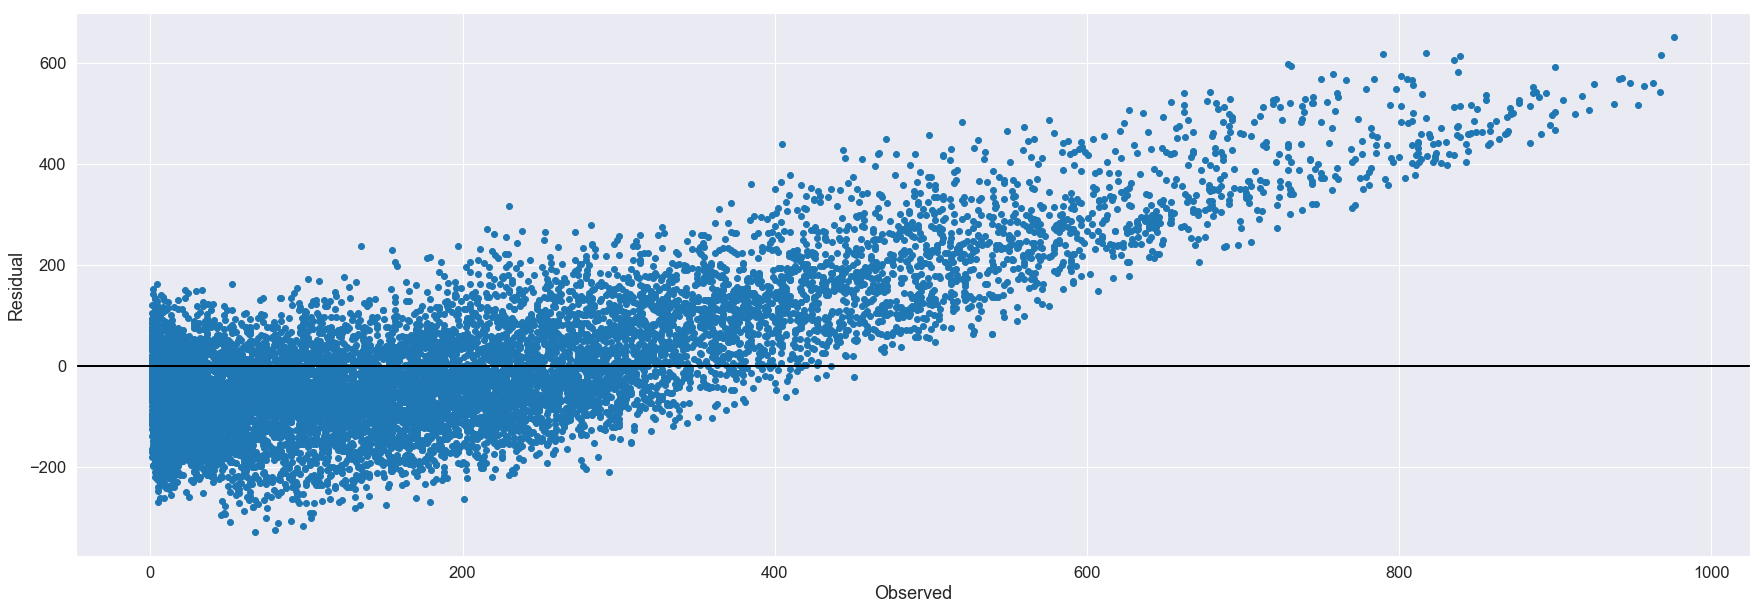

In [9]:
predicted = cross_val_predict(lin_reg, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, y - predicted)
ax.axhline(lw=2, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual');


We compute goodness of fit scores R-Squared and RMSE, for each CV fold 

In [10]:
r2_scores = cross_val_score(lin_reg, X, y, cv=10)
mse_scores = cross_val_score(lin_reg, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)
print("R-squared: {}".format(np.round(r2_scores, 4)))
print("RMSE: {}".format(np.round(rmse_scores, 2)))

R-squared: [0.3989 0.3558 0.3873 0.388  0.4249 0.4157 0.3738 0.3934 0.3959 0.4087]
RMSE: [140.04 144.22 142.33 136.18 136.92 144.97 146.8  146.86 145.07 137.47]


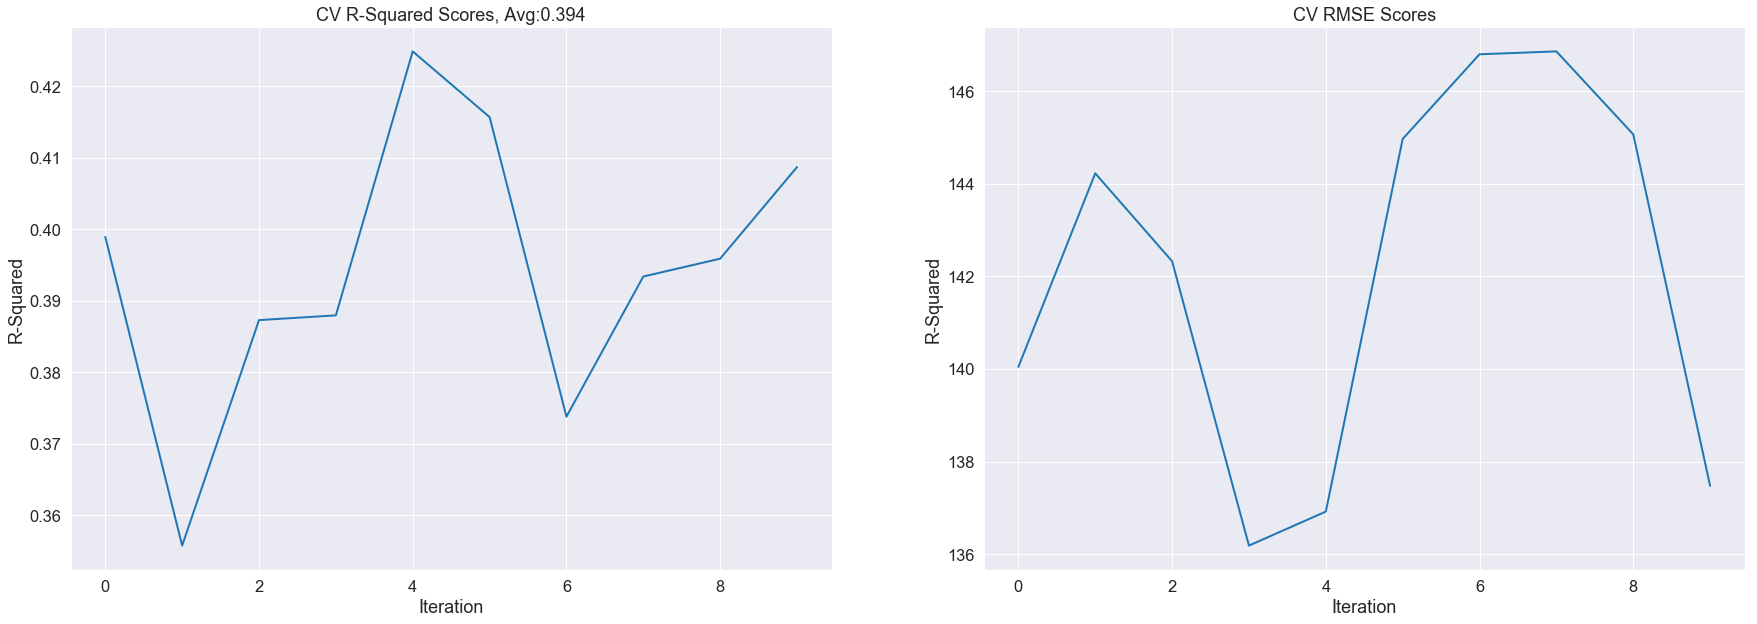

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot([i for i in range(len(r2_scores))], r2_scores, lw=2)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('R-Squared')
ax1.title.set_text("CV R-Squared Scores, Avg:{}".format(np.round(np.average(r2_scores), 3)))
ax2.plot([i for i in range(len(rmse_scores))], rmse_scores, lw=2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('R-Squared')
ax2.title.set_text("CV RMSE Scores")

### Test Dataset Performance

In [11]:
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df': mlutils.transform_ohe(X_test, le, ohe, col_name),
                                   'col_name': col_name})
    
test_feature_df_list = [X_test[all_num_cols]]
test_feature_df_list.extend([enc['feature_df'] 
                             for enc in test_encoded_attr_list 
                             if enc['col_name'] in subset_cat_cols])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape of testing set: {}".format(test_df_new.shape))
test_df_new.head()

Shape of testing set: (5736, 19)


,temp,humidity,windspeed,hour,weekday,month,year,season_Fall,season_Spring,season_Summer,season_Winter,is_holiday_0,is_holiday_1,weather_cond_1,weather_cond_2,weather_cond_3,weather_cond_4,is_workday_0,is_workday_1
0,0.80,0.27,0.1940,19,6,6,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.24,0.41,0.2239,20,1,1,1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.32,0.66,0.2836,2,5,10,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.78,0.52,0.3582,19,2,5,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.26,0.56,0.3881,0,4,1,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [12]:
X_test = test_df_new
y_test = y_test.values.reshape(-1,1)

y_pred = lin_reg.predict(X_test)

residuals = y_test - y_pred

In [13]:
r2_score = lin_reg.score(X_test, y_test)
print("R-squared: {0:4.3f}".format(r2_score))
print("MSE: {0:4.2f}".format(metrics.mean_squared_error(y_test, y_pred)))

R-squared: 0.402
MSE: 19063.00


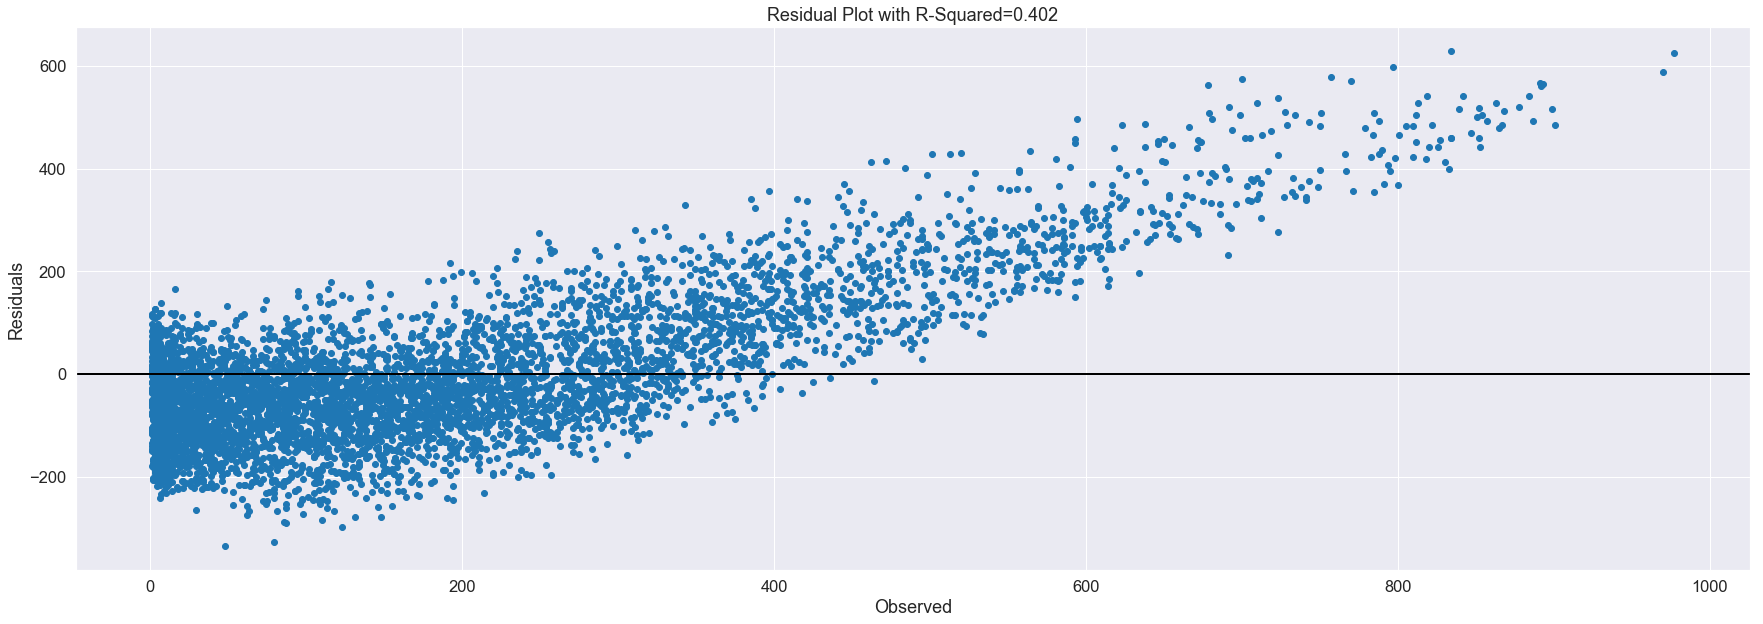

In [14]:
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot with R-Squared={0:4.3f}".format(np.average(r2_score)));

## StatsModels

In [15]:
import statsmodels.api as sm

# Set the independent variable
X = X.values.tolist()

# This handles the intercept. 
# Statsmodel takes 0 intercept by default
X = sm.add_constant(X)

X_test = X_test.values.tolist()
X_test = sm.add_constant(X_test)


# Build OLS model
model = sm.OLS(y, X)
results = model.fit()

# Get the predicted values for dependent variable
pred_y = results.predict(X_test)

# View Model stats
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     508.2
Date:                Wed, 06 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:46:31   Log-Likelihood:                -74221.
No. Observations:               11643   AIC:                         1.485e+05
Df Residuals:                   11627   BIC:                         1.486e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3509     11.086     -0.122      0.9

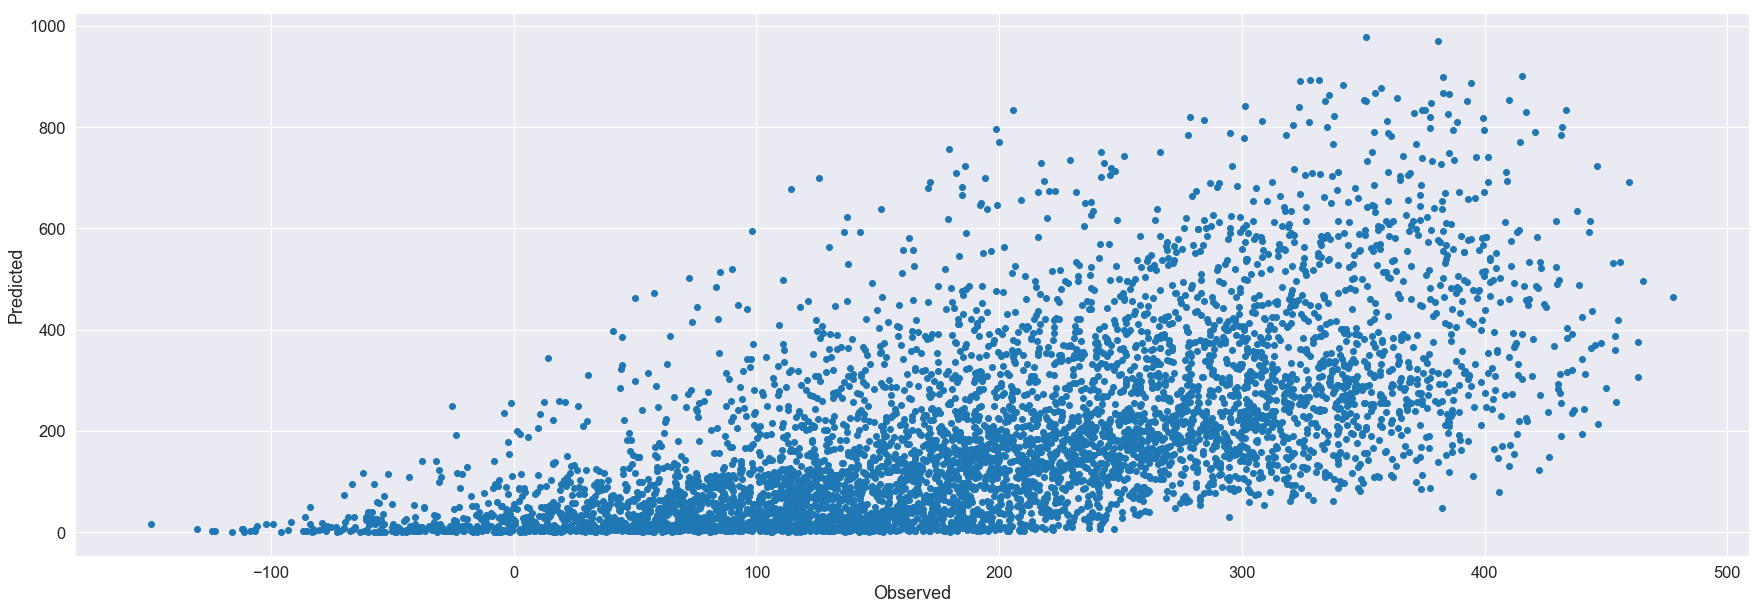

In [16]:
plt.scatter(pred_y, y_test)
plt.xlabel('Observed')
plt.ylabel('Predicted');